---
format:
  html:
   code-fold: true
   code-summary: "Show the code"
   toc: true
   page-layout: full
jupyter: Python3

---

# Part III - Museum Collections - MET, MoMA, British Museum, and Tate

In [434]:
import pandas as pd
import geopandas as gpd
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
import numpy as np
pd.set_option('display.max_columns', None)

# 0. World Museum at a Glance

In [441]:
world_museums = pd.read_csv("./Final_Data/Museum Collection Numbers.csv").dropna()
world_museums_location = gpd.read_file("./Final_Data/world_museum_location.geojson")
world_museums['Quantity'] = world_museums['Quantity'].astype(int)
world_museums['Museum'] = world_museums['Museum'].astype(object)

In [442]:
location = world_museums_location.merge(world_museums, on="Museum")
location.explore(
     tiles="cartodbpositron",
)

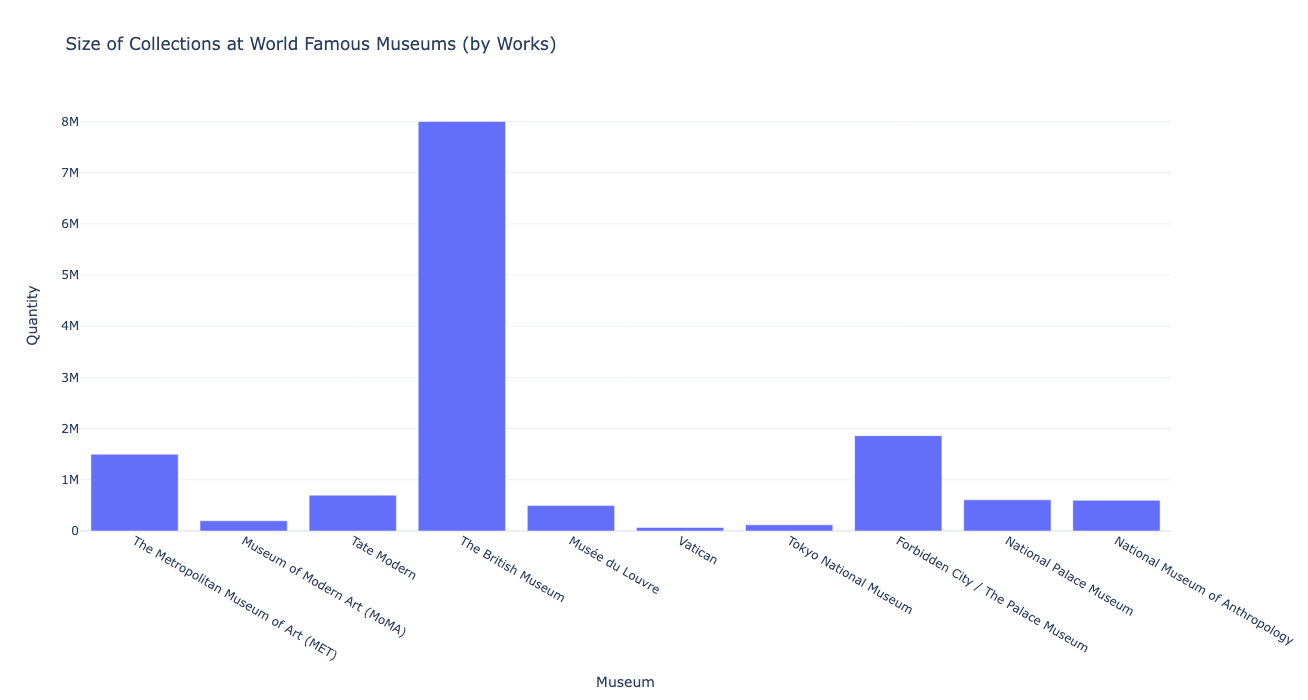

In [437]:
fig = px.bar(world_museums, x='Museum', y='Quantity', 
             title='Size of Collections at World Famous Museums (by Works)', 
             height=700, width=1000,
             template="plotly_white")
fig.show()



# 1. MET & MoMA's Open Access Digital Collection

https://github.com/MuseumofModernArt 

https://github.com/metmuseum/openaccess


In [438]:
# Load Data
met = pd.read_csv("./Final_Data/MetObjects.txt")
moma_artist = pd.read_csv("./Final_Data/Moma_Artists.txt")
moma_artwork = pd.read_csv("./Final_Data/Moma_artworks.txt")

/var/folders/q3/y0zpvj752qg3_3nvpkx6v2300000gn/T/ipykernel_14921/3272275578.py:2: DtypeWarning:

Columns (5,7,10,11,12,13,14,34,35,36,37,38,39,40,41,42,43,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.



## 1.1 Department Breakdown

In [439]:
met_dept = pd.DataFrame(met.groupby(['Department']).size()).reset_index()
met_dept = met_dept.rename(columns={met_dept.columns[1]: 'Counts'})
moma_dept = pd.DataFrame(moma_artwork.groupby(['Department']).size()).reset_index()
moma_dept = moma_dept.rename(columns={moma_dept.columns[1]: 'Counts'})

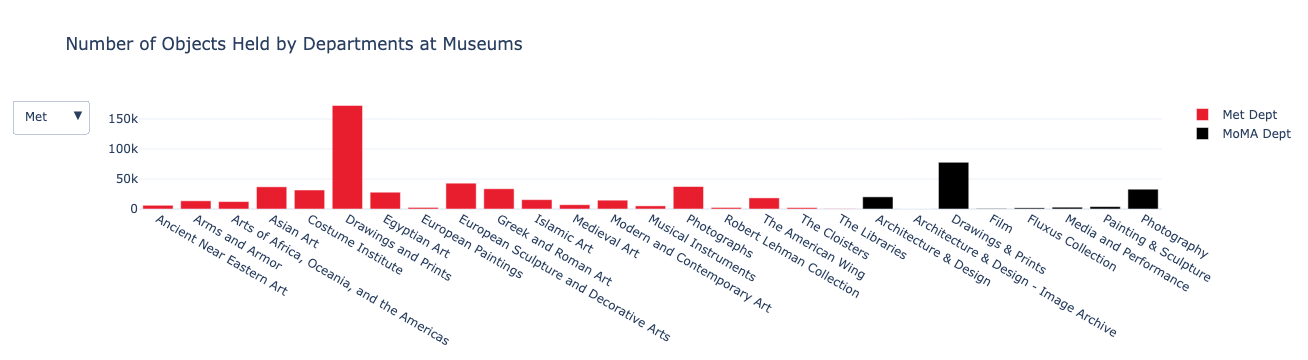

In [440]:
fig = go.Figure()


fig.add_trace(
    go.Bar(x=met_dept['Department'], 
           y=met_dept['Counts'], 
           name='Met Dept',
          marker=dict(color="#E81D2E")))


fig.add_trace(
    go.Bar(x=moma_dept['Department'], 
           y=moma_dept['Counts'], 
           name='MoMA Dept',
          marker=dict(color="Black")))

#add dropdown

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(label="Met",
                    method="update",
                    args=[{"visible": [True, False]},
                        {"title": "Metropolitan Museum of Art Department Breakdown",
                         "annotations": []}]),
                dict(label="MoMA",
                    method="update",
                    args=[{"visible": [False, True]},
                        {"title": "Modern Museum of Art Department Breakdown",
                         "annotations": []}])
            ]))])

fig.update_layout(title_text="Number of Objects Held by Departments at Museums", 
                  height=700,
                 template='plotly_white')
fig.show()


## 1.2 Top Artists

Excluding Unknown and Anonymous, of course. 
For met - excluding Companies - they are usually objects produced or owned by companies. 

In [166]:
met_top_artist = pd.DataFrame(met.groupby(['Artist Display Name']).size()).reset_index()
met_top_artist = met_top_artist.rename(columns={met_top_artist.columns[1]: 'Counts'})
met_top_artist_with_Co = met_top_artist[(met_top_artist['Artist Display Name'] != 'Unknown') & 
                                ~met_top_artist['Artist Display Name'].str.contains('Anonymous', case=False) &
                                (met_top_artist['Artist Display Name'] != 'Unidentified artist')]

met_top_artist = met_top_artist[(met_top_artist['Artist Display Name'] != 'Unknown') & 
                                ~met_top_artist['Artist Display Name'].str.contains('Anonymous', case=False) &
                                ~met_top_artist['Artist Display Name'].str.contains('company', case=False) &
                                ~met_top_artist['Artist Display Name'].str.contains('Co.', case=False) &
                                (met_top_artist['Artist Display Name'] != 'Unidentified artist')]
 
moma_top_artist = pd.DataFrame(moma_artwork.groupby(['Artist']).size()).reset_index()
moma_top_artist = moma_top_artist.rename(columns={moma_top_artist.columns[1]: 'Counts'})
moma_top_artist = moma_top_artist[(moma_top_artist['Artist'] != 'Unknown') & 
                                  (moma_top_artist['Artist'] != 'Anonymous') &
                                  ~moma_top_artist['Artist'].str.contains('Unidentified', case=False)]

In [159]:
met_top_30 = met_top_artist.loc[met_top_artist['Counts'].nlargest(30).index]
moma_top_30 = moma_top_artist.loc[moma_top_artist['Counts'].nlargest(30).index]

In [184]:
met_30_artworks = met[met['Artist Display Name'].isin(met_top_30['Artist Display Name'])] 
moma_30_artworks = moma_artwork[moma_artwork['Artist'].isin(moma_top_30['Artist'])] 

In [193]:
moma_30_work_breakdown = moma_30_artworks.groupby(['Artist', 'Department']).size().reset_index()
moma_30_work_breakdown = moma_30_work_breakdown.rename(columns={moma_30_work_breakdown.columns[2]: 'Counts'})

met_30_work_breakdown = met_30_artworks.groupby(['Artist Display Name', 'Department']).size().reset_index()
met_30_work_breakdown = met_30_work_breakdown.rename(columns={met_30_work_breakdown.columns[2]: 'Counts'})


In [399]:
moma_30_work_pivot = moma_30_work_breakdown.pivot(index='Artist', columns='Department', values="Counts").fillna(0)

met_30_work_pivot = met_30_work_breakdown.pivot(index='Artist Display Name', columns='Department', values="Counts").fillna(0)

In [400]:
order = moma_top_30['Artist'].values
moma_30_work_pivot.index = pd.CategoricalIndex(moma_30_work_pivot.index, categories=order, ordered=True)
moma_30_work_pivot = moma_30_work_pivot.sort_index()

In [401]:
order = met_top_30['Artist Display Name'].values
met_30_work_pivot.index = pd.CategoricalIndex(met_30_work_pivot.index, categories=order, ordered=True)
met_30_work_pivot = met_30_work_pivot.sort_index()

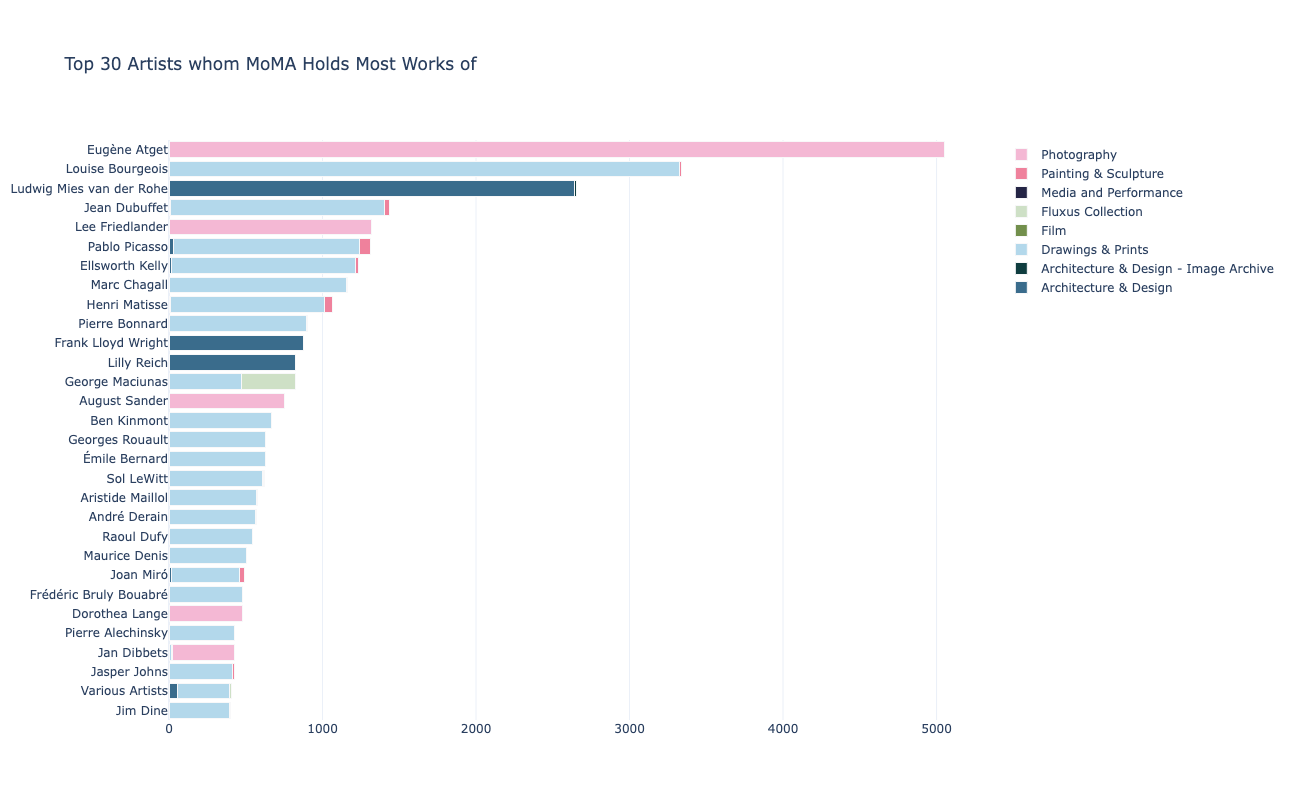

In [443]:
fig = go.Figure()

colors = ['#3A6C8C', '#0F3D3F','#B3D8EB','#728F4C','#CEE0C6','#242545','#EF819C','#F4B8D4']

headings = ['Architecture & Design', 'Architecture & Design - Image Archive', 'Drawings & Prints', 'Film', 'Fluxus Collection', 'Media and Performance', 'Painting & Sculpture', 'Photography']



import plotly.graph_objects as go


x_data = np.transpose(moma_30_work_pivot.values)
y_data = moma_30_work_pivot.index.values


for heading, xd, colors in zip(headings, x_data, colors):
    fig.add_trace(go.Bar(
            x=xd, 
            y=y_data,
            name=heading,
            orientation='h',
            marker=dict(
                color=colors,
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

fig.update_layout(
    height=800,
    width=1500,
    yaxis=dict(autorange="reversed"),
    barmode='stack',
    margin=dict(l=120, r=10, t=140, b=80),
    showlegend=True,
    template='plotly_white',
    autosize=True,
    title='Top 30 Artists whom MoMA Holds Most Works of'
)



fig.show()

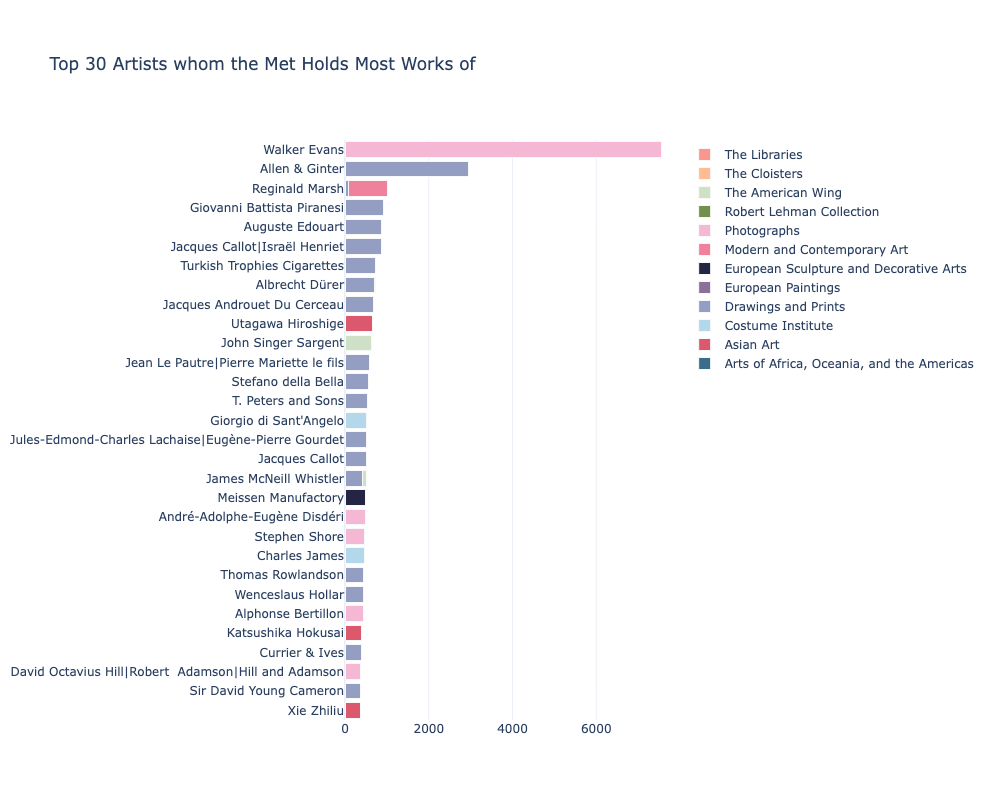

In [444]:
fig = go.Figure()

colors = ['#3A6C8C','#dc596d','#B3D8EB','#949EC3', '#8B7099', '#242545','#EF819C','#F4B8D4','#728F4C','#CEE0C6', '#ffbb93', '#fa958f' ]

headings = met_30_work_pivot.columns.to_numpy()



import plotly.graph_objects as go


x_data = np.transpose(met_30_work_pivot.values)
y_data = met_30_work_pivot.index.values


for heading, xd, colors in zip(headings, x_data, colors):
    fig.add_trace(go.Bar(
            x=xd, 
            y=y_data,
            name=heading,
            orientation='h',
            marker=dict(
                color=colors,
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

fig.update_layout(
    height=800,
    width=1500,
    yaxis=dict(autorange="reversed"),
    barmode='stack',
    margin=dict(l=120, r=10, t=140, b=80),
    showlegend=True,
    template='plotly_white',
    autosize=True,
    title='Top 30 Artists whom the Met Holds Most Works of'
)



fig.show()

## 1.3 Top Nationalities of Artists

In [424]:
filtered = met.dropna(subset=['Artist Nationality'])
filtered.head(10)

,Object Number,Is Highlight,Is Timeline Work,Is Public Domain,Object ID,Gallery Number,Department,AccessionYear,Object Name,Title,Culture,Period,Dynasty,Reign,Portfolio,Constituent ID,Artist Role,Artist Prefix,Artist Display Name,Artist Display Bio,Artist Suffix,Artist Alpha Sort,Artist Nationality,Artist Begin Date,Artist End Date,Artist Gender,Artist ULAN URL,Artist Wikidata URL,Object Date,Object Begin Date,Object End Date,Medium,Dimensions,Credit Line,Geography Type,City,State,County,Country,Region,Subregion,Locale,Locus,Excavation,River,Classification,Rights and Reproduction,Link Resource,Object Wikidata URL,Metadata Date,Repository,Tags,Tags AAT URL,Tags Wikidata URL
0,1979.486.1,False,False,False,1,NaN,The American Wing,1979.0,Coin,One-dollar Liberty Head Coin,NaN,NaN,NaN,NaN,NaN,16429,Maker,,James Barton Longacre,"American, Delaware County, Pennsylvania 1794–1...",,"Longacre, James Barton",American,1794,1869,NaN,http://vocab.getty.edu/page/ulan/500011409,https://www.wikidata.org/wiki/Q3806459,1853,1853,1853,Gold,Dimensions unavailable,"Gift of Heinz L. Stoppelmann, 1979",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/1,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
1,1980.264.5,False,False,False,2,NaN,The American Wing,1980.0,Coin,Ten-dollar Liberty Head Coin,NaN,NaN,NaN,NaN,NaN,107,Maker,,Christian Gobrecht,1785–1844,,"Gobrecht, Christian",American,1785,1844,NaN,http://vocab.getty.edu/page/ulan/500077295,https://www.wikidata.org/wiki/Q5109648,1901,1901,1901,Gold,Dimensions unavailable,"Gift of Heinz L. Stoppelmann, 1980",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/2,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
9,1979.486.3,False,False,False,10,NaN,The American Wing,1979.0,Coin,Two-and-a-half-dollar Indian Head Coin,NaN,NaN,NaN,NaN,NaN,108,Maker,,Bela Lyon Pratt,1867–1917,,"Pratt, Bela Lyon",American,1867,1917,NaN,http://vocab.getty.edu/page/ulan/500095555,https://www.wikidata.org/wiki/Q4881787,1912,1912,1912,Gold,Dimensions unavailable,"Gift of Heinz L. Stoppelmann, 1979",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/10,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
10,1979.486.2,False,False,False,11,NaN,The American Wing,1979.0,Coin,Two-and-a-half-dollar Liberty Head Coin,NaN,NaN,NaN,NaN,NaN,107,Maker,,Christian Gobrecht,1785–1844,,"Gobrecht, Christian",American,1785,1844,NaN,http://vocab.getty.edu/page/ulan/500077295,https://www.wikidata.org/wiki/Q5109648,1907,1907,1907,Gold,Dimensions unavailable,"Gift of Heinz L. Stoppelmann, 1979",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/11,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
11,1979.486.7,False,False,False,12,NaN,The American Wing,1979.0,Coin,Twenty-dollar Liberty Head Coin,NaN,NaN,NaN,NaN,NaN,16429,Maker,,James Barton Longacre,"American, Delaware County, Pennsylvania 1794–1...",,"Longacre, James Barton",American,1794,1869,NaN,http://vocab.getty.edu/page/ulan/500011409,https://www.wikidata.org/wiki/Q3806459,1876,1876,1876,Gold,Dimensions unavailable,"Gift of Heinz L. Stoppelmann, 1979",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/12,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
12,1979.486.4,False,False,False,13,NaN,The American Wing,1979.0,Coin,Five-dollar Indian Head Coin,NaN,NaN,NaN,NaN,NaN,108,Maker,,Bela Lyon Pratt,1867–1917,,"Pratt, Bela Lyon",American,1867,1917,NaN,http://vocab.getty.edu/page/ulan/500095555,https://www.wikidata.org/wiki/Q4881787,1910,1910,1910,Gold,Dimensions unavailable,"Gift of Heinz L. Stoppelmann, 1979",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/13,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
13,1979.486.5,False,False,F

In [432]:
word_counts = filtered['Artist Nationality'].str.split('[\s,|]', expand=True).stack().value_counts()
word_counts = pd.DataFrame(word_counts)
word_counts

,0
American,126558
,117820
French,91399
British,57935
Italian,44062
German,19897
born,12840
Netherlandish,12649
Japanese,8342
Dutch,6608


# 2. Digital Access to Collection Comparison - Chinese Art as an Example

This section shows three levels / ways of acquiring digital collection information, which involves different levels of resources and dedication from the museum. 

## 2.1 MET - Open Access CSV / JSON file

In [71]:
met_china_art = met.loc[(met['Culture'] == "China") & (met['Is Highlight'] == True)]

In [72]:
met_china_art

,Object Number,Is Highlight,Is Timeline Work,Is Public Domain,Object ID,Gallery Number,Department,AccessionYear,Object Name,Title,Culture,Period,Dynasty,Reign,Portfolio,Constituent ID,Artist Role,Artist Prefix,Artist Display Name,Artist Display Bio,Artist Suffix,Artist Alpha Sort,Artist Nationality,Artist Begin Date,Artist End Date,Artist Gender,Artist ULAN URL,Artist Wikidata URL,Object Date,Object Begin Date,Object End Date,Medium,Dimensions,Credit Line,Geography Type,City,State,County,Country,Region,Subregion,Locale,Locus,Excavation,River,Classification,Rights and Reproduction,Link Resource,Object Wikidata URL,Metadata Date,Repository,Tags,Tags AAT URL,Tags Wikidata URL
30457,1981.4.1a–o,True,False,True,36131,NaN,Asian Art,1981.0,Album,清 龔賢 墨筆山水詩畫 冊|清 龔賢 自題 山水十六開 冊|Landscap...,China,Qing dynasty (1644–1911),NaN,NaN,NaN,1170,Artist,,Gong Xian,"Chinese, 1619–1689",,GONG XIAN,Chinese,1619,1689,NaN,http://vocab.getty.edu/page/ulan/500125754,https://www.wikidata.org/wiki/Q3110482,1688,1688,1688,Fifteen leaves from an album (1980.516.2a–c an...,10 3/4 x 16 1/8 in. (27.3 x 41 cm),"Gift of Douglas Dillon, 1981",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paintings,NaN,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q29383237,NaN,"Metropolitan Museum of Art, New York, NY",Poetry|Landscapes,http://vocab.getty.edu/page/aat/300055931|http...,https://www.wikidata.org/wiki/Q482|https://www...
33815,1985.214.99,True,True,True,39637,NaN,Asian Art,1985.0,Pendant,戰國 絞絲龍形玉佩|Knotted dragon pendant,China,Eastern Zhou dynasty (770–256 B.C.),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3rd century BCE,-299,-99,Jade (nephrite),H. 3 1/8 in. (7.9 cm); W. 2 1/16 in. (5.2 cm),"Gift of Ernest Erickson Foundation, 1985",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jade,NaN,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q29383288,NaN,"Metropolitan Museum of Art, New York, NY",Dragons,http://vocab.getty.edu/page/aat/300375726,https://www.wikidata.org/wiki/Q7559
33827,18.56.36,True,True,True,39649,204.0,Asian Art,1918.0,Bowl,NaN,China,Five Dynasties (907–960),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10th century,900,960,Stoneware with carved and incised decoration u...,H. 4 1/2 in. (11 .4 cm); Diam. 10 5/8 in. (27 cm),"Rogers Fund, 1918",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ceramics,NaN,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q29383290,NaN,"Metropolitan Museum of Art, New York, NY",Dragons,http://vocab.getty.edu/page/aat/300375726,https://www.wikidata.org/wiki/Q7559
33842,37.191.1,True,True,True,39666,202.0,Asian Art,1937.0,Jar,NaN,China,"Ming dynasty (1368–1644), Xuande mark and peri...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,early 15th century,1400,1433,Porcelain painted with cobalt blue under trans...,H. 19 in. (48.3 cm); Diam. 19 in. (48.3 cm),"Gift of Robert E. Tod, 1937",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ceramics,NaN,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q29383294,NaN,"Metropolitan Museum of Art, New York, NY",Dragons,http://vocab.getty.edu/page/aat/300375726,https://www.wikidata.org/wiki/Q7559
33844,1981.276,True,True,True,39668,NaN,Asian Art,1981.0,Handscroll,"北宋 郭熙 樹色平遠圖 卷 |Old Trees, Level Dist...",China,Northern Song dynasty (960–1127),NaN,NaN,NaN,1149,Artist,,Guo Xi,"Chinese, ca. 1000–ca. 1090",,Guo Xi,Chinese,1000,1090,NaN,http://vocab.getty.edu/page/ulan/500125758,https://www.wikidata.org/wiki/Q536645,ca. 1080,1070,1090,Handscroll; ink and color on silk,Image: 14 × 41 1/8 in. (35.6 × 104.4 cm)\r\nOv...,"Gift of John M. Crawford Jr., in honor of Doug...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paintings,NaN,http://www.metmuseum.org/art/collection/search...,https://www.wikidata.org/wiki/Q29383298,NaN,"Metropolitan Museum of Art, New York, NY",Trees|Landscapes,http://vocab.getty.edu/page/aat/300132410|http...,https:

In [13]:
moma_artist.head()

,ConstituentID,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate,Wiki QID,ULAN
0,1,Robert Arneson,"American, 1930–1992",American,Male,1930,1992,NaN,NaN
1,2,Doroteo Arnaiz,"Spanish, born 1936",Spanish,Male,1936,0,NaN,NaN
2,3,Bill Arnold,"American, born 1941",American,Male,1941,0,NaN,NaN
3,4,Charles Arnoldi,"American, born 1946",American,Male,1946,0,Q1063584,500027998.0
4,5,Per Arnoldi,"Danish, born 1941",Danish,Male,1941,0,NaN,NaN


## 2.2 British Museum and VAM - Access Search Result Download 

## 2.3 Web Scrapping - Philadelphia Museum of Art as an example 